In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import PIL
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.backend import clear_session

from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception

In [2]:
# define paths
INPUT_DIR = '/kaggle/input/70-dog-breedsimage-data-set'
OUTPUT_DIR = '/kaggle/working/'

TRAIN_DIR = '/kaggle/input/70-dog-breedsimage-data-set/train'
VAL_DIR = '/kaggle/input/70-dog-breedsimage-data-set/valid'
TEST_DIR = '/kaggle/input/70-dog-breedsimage-data-set/test'

DIMS = (224,224)
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

In [3]:
# generate datasets
# ImageDatagenerator to load the images in batches and perform data augmentation

data_gen = ImageDataGenerator(rescale=1/255)

In [4]:
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TRAIN_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=VAL_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TEST_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [5]:
label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless',
       'American Spaniel', 'Basenji', 'Basset', 'Beagle',
       'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim',
       'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi',
       'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier',
       'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow',
       'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote',
       'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound',
       'French Bulldog', 'German Sheperd', 'Golden Retriever',
       'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael',
       'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor',
       'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese',
       'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull',
       'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler',
       'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei',
       'Shiba In

In [6]:
IMG_SHAPE = (224,224,3)
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(70,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
Total params: 22,014,754
Trainable params: 211,970
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)
# checkpoint = ModelCheckpoint(filepath='/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [9]:
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=80, verbose=1, callbacks=[reduce_lr,es])

Epoch 1/80
248/248 [==============================] - 51s 166ms/step - loss: 1.1074 - accuracy: 0.7402 - val_loss: 0.9365 - val_accuracy: 0.8274 - lr: 0.0100
Epoch 2/80
248/248 [==============================] - 20s 82ms/step - loss: 0.6004 - accuracy: 0.8402 - val_loss: 0.6783 - val_accuracy: 0.8690 - lr: 0.0100
Epoch 3/80
248/248 [==============================] - 20s 79ms/step - loss: 0.5226 - accuracy: 0.8608 - val_loss: 0.6130 - val_accuracy: 0.8943 - lr: 0.0100
Epoch 4/80
248/248 [==============================] - 20s 81ms/step - loss: 0.5010 - accuracy: 0.8663 - val_loss: 1.0991 - val_accuracy: 0.8780 - lr: 0.0100
Epoch 5/80
248/248 [==============================] - 19s 75ms/step - loss: 0.4376 - accuracy: 0.8765 - val_loss: 1.2797 - val_accuracy: 0.8676 - lr: 0.0100
Epoch 6/80
248/248 [==============================] - 19s 78ms/step - loss: 0.4686 - accuracy: 0.8776 - val_loss: 1.2037 - val_accuracy: 0.9077 - lr: 0.0100
Epoch 7/80
248/248 [==============================] - 19s

In [10]:
clear_session()

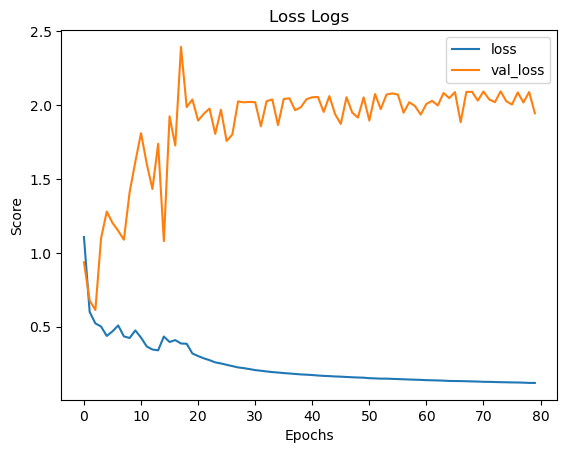

In [11]:
plt.plot(logs.history['loss'], label='loss')
plt.plot(logs.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Loss Logs')
plt.show()

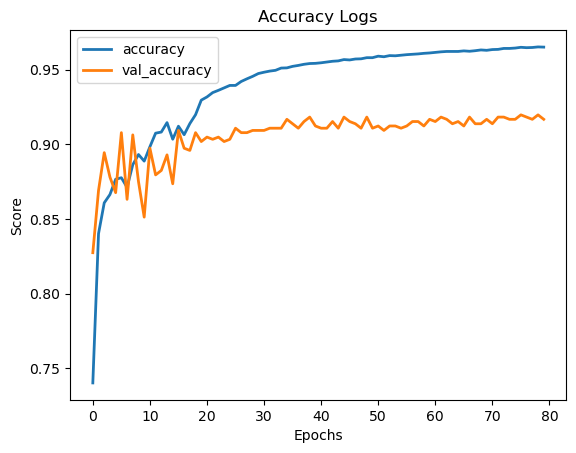

In [12]:

plt.plot(logs.history['accuracy'], label='accuracy', linewidth=2)
plt.plot(logs.history['val_accuracy'], label='val_accuracy', linewidth=2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Accuracy Logs')
plt.show()

In [13]:
model.evaluate(val_data)

22/22 [==============================] - 3s 113ms/step - loss: 2.0178 - accuracy: 0.9171


[2.017777919769287, 0.9171428680419922]

In [14]:
model.evaluate(test_data)

22/22 [==============================] - 3s 151ms/step - loss: 0.3469 - accuracy: 0.9371


[0.34687578678131104, 0.9371428489685059]

In [15]:
def predictor(img):
    display(img)
    arr = img_to_array(img)
    arr = arr/255.0
    arr = np.expand_dims(arr,0)
    res = model.predict(arr)
    print(res.shape)
    idx = res.argmax()
    return label_mapper[idx], res[0][idx]

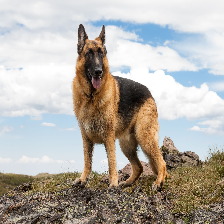

1/1 [==============================] - 2s 2s/step
(1, 70)


('German Sheperd', 0.67222184)

In [16]:
# requests.get(image_url, stream=True).raw
url = 'https://www.google.com/url?sa=i&url=https%3A%2F%2Fencrypted-tbn3.gstatic.com%2Flicensed-image%3Fq%3Dtbn%3AANd9GcRv7Ev1T8O6as52YDwz3YDa9ya3-xv5SpMw3Lk_mZHqxwWvGDCw47ZaixFiTefWHF_dHHqDFFSYk2ZRKfU&psig=AOvVaw2brgj8mLWs5S3os1vdjdgh&ust=1690324655029000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCMDy4pa0qIADFQAAAAAdAAAAABAE'
response = requests.get(url)
img = load_img(BytesIO(response.content), target_size=DIMS)

val,prob = predictor(img)
val,prob

In [17]:
# save the model
os.chdir(OUTPUT_DIR)
model.save('model.h5')